# Metodi informatici per la gestione aziendale

# Librerie

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pandas import set_option 

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import surprise

from nltk.cluster import KMeansClusterer, cosine_distance

from sklearn.ensemble import RandomForestClassifier

from sklearn import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

from surprise import accuracy, Dataset, KNNBasic
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
import json

from surprise import Dataset, SVD
from surprise.model_selection import cross_validate

import numpy as np
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
# for interactive visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

import multiprocessing
from multiprocessing import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

from surprise import accuracy, Dataset, KNNBasic, Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

# 1) Analisi esplorative

In [2]:
# Importiamo i dati:
df = pd.read_json('renttherunway.json', lines = True)
df = df.dropna()
df.head(3)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"


In [3]:
# Aggiustiamo i rating perchè sono raddopiati
df.rating = df.rating /2

# Modifichiamo la colonna altezza utilizzando i cm:
h_centimetri = []
for i in df['height']:
    val = 0
    h = str(i)
    piede = int((h[0]))
    pollice = int((h[3]))
    if piede == 4:
        val += 121.92
        ngul = pollice*2.54
        val += ngul
    elif piede == 5:
        val += 152.4
        ngul = pollice*2.54
        val += ngul
    else:
        val += 182.88
        ngul = pollice*2.54
        val += ngul
    h_centimetri.append(val)
df['height'] = h_centimetri

# Sistemiamo anche la variabile delle libre mettendola come numerica e in Kg:
peso = []
for w in df['weight']:
    ww = str(w)
    ww = ww[0:-3]
    ww = int(ww)
    ww = ww*0.45359237   #Conversione in Kg
    peso.append(ww)
df.weight = peso

In [4]:
df.head(3)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,62.142155,5.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,59.874193,5.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,"June 18, 2013"
3,fit,909926,34c,126335,61.234970,4.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,"February 12, 2014"


rating
1.0      783
2.0     2205
3.0     8341
4.0    40761
5.0    94291
Name: user_id, dtype: int64

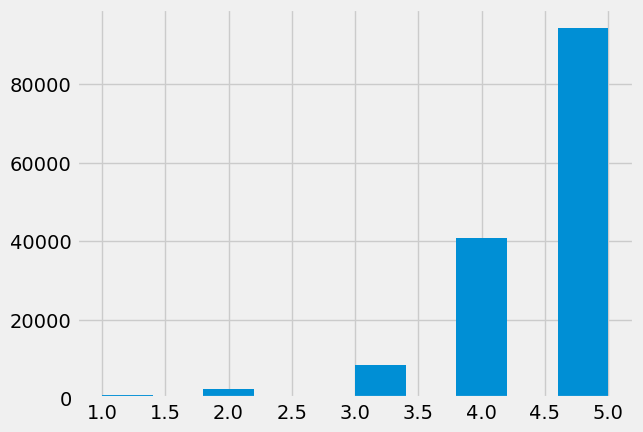

In [5]:
# Vediamo l'istogramma dei rating:
df.rating.hist()
df.groupby('rating').user_id.count()

In [6]:
# Analisi variabili quantitative
description = df.describe()
print('Statistiche descrittive per dati quantitativi:')
description

Statistiche descrittive per dati quantitativi:


,user_id,item_id,weight,rating,height,size,age
count,146381.000000,1.463810e+05,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000
mean,498991.574528,1.052277e+06,62.237350,4.540992,164.389367,11.437919,34.089800
std,289658.524623,8.091076e+05,9.770462,0.718926,7.104190,7.826784,8.113217
min,9.000000,1.233730e+05,22.679619,1.000000,124.460000,0.000000,0.000000
25%,249294.000000,1.956130e+05,55.791862,4.000000,160.020000,4.000000,29.000000
50%,499034.000000,9.618190e+05,61.234970,5.000000,165.100000,9.000000,32.000000
75%,750840.000000,1.687082e+06,67.131671,5.000000,170.180000,16.000000,37.000000
max,999997.000000,2.966087e+06,136.077711,5.000000,198.120000,58.000000,117.000000


In [7]:
# Analisi variabili qulitative:
body_su_rating = df.groupby(['body type', 'rating']).rating.count()
body_su_rating

body type          rating
apple              1.0          34
                   2.0          62
                   3.0         293
                   4.0        1188
                   5.0        2232
athletic           1.0         173
                   2.0         528
                   3.0        1951
                   4.0       10245
                   5.0       24621
full bust          1.0          81
                   2.0         176
                   3.0         608
                   4.0        3228
                   5.0        6704
hourglass          1.0         242
                   2.0         672
                   3.0        2572
                   4.0       12236
                   5.0       28260
pear               1.0          74
                   2.0         274
                   3.0        1107
                   4.0        5328
                   5.0       11268
petite             1.0         118
                   2.0         310
                   3.0       

In [8]:
category_su_rating = df.groupby('category').rating.count().sort_values(ascending = False)
category_su_rating.head(15)

category
dress         70474
gown          33278
sheath        14691
shift          4039
jumpsuit       4019
top            3780
maxi           2600
romper         2447
jacket         1871
mini           1417
skirt          1206
sweater         919
coat            770
blazer          620
shirtdress      564
Name: rating, dtype: int64

In [9]:
# Vediamo quali sono gli utenti che hanno dato più voti ai vestiti:
utenti_chiaccheroni = df.groupby(by= 'user_id').rating.count().sort_values(ascending = False)
utenti_piu_chiaccheroni = utenti_chiaccheroni.head(10)        # I 10 id_user che valutano di più
utenti_piu_chiaccheroni

user_id
691468    436
32925     292
45337     140
833675    128
742630    124
269712    105
215971     96
257847     87
252311     83
630850     79
Name: rating, dtype: int64

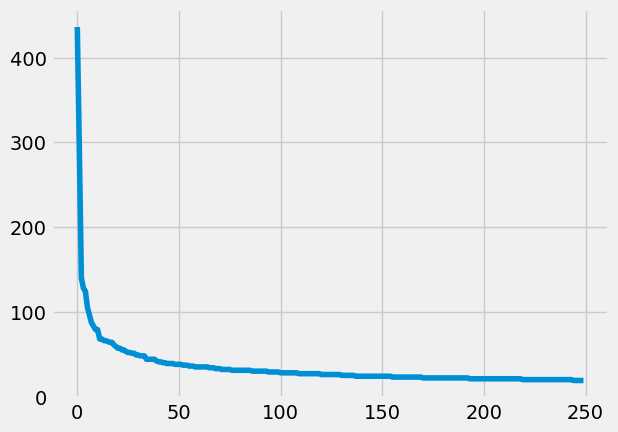

In [10]:
plt.plot(range(len(utenti_chiaccheroni.head(250))), utenti_chiaccheroni.head(250))

In [11]:
category_su_rating = df.groupby('rented for').rating.count().sort_values(ascending = False)
category_su_rating

rented for
wedding            42622
formal affair      30496
party              27198
everyday           13263
work               12124
other              11510
date                5929
vacation            3238
party: cocktail        1
Name: rating, dtype: int64

# Configurazione ottimale

In [6]:
df_ridotto = df[['user_id', 'item_id', 'rating']]
df_ridotto = df_ridotto.dropna()
df_ridotto = df_ridotto.drop_duplicates(['user_id','item_id'], keep='last')
lista_item = df_ridotto.item_id
df_ridotto['rating'] = df_ridotto['rating'].astype('int8')

In [7]:
# Teniamo i più votati
most_rated_items = df_ridotto.item_id.value_counts().head(400).index
most_rating_users = df_ridotto.user_id.value_counts().head(15000).index

df_ridotto = df_ridotto[df_ridotto.item_id.isin(most_rated_items)]
df_ridotto = df_ridotto[df_ridotto.user_id.isin(most_rating_users)]

In [14]:
df_ridotto

,user_id,item_id,rating
4,151944,616682,5
9,154309,1729232,5
12,87660,1295171,5
14,721308,123793,5
19,16800,1229740,5
...,...,...,...
192516,763229,1566348,4
192524,62024,152662,3
192526,255511,166633,5
192531,136279,330238,4


In [8]:
# Creiamo un oggetto per convertire il DF in un formato utilizzabile da Surprise:
reader = Reader(rating_scale=(1, 5))

# Utilizziamo il Grid Search:
ds_gridset = Dataset.load_from_df(df_ridotto.sample(frac=0.9)[['user_id', 'item_id', 'rating']], reader)
param_grid = {
    'k': [1, 2, 5,],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False]
        }
    }

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mse'])
gs.fit(ds_gridset)


# Vediamo i risultati:
print(f'Best RMSE = {gs.best_score["rmse"]:.4f}')
print(f'Best MSE = {gs.best_score["mse"]:.4f}')
print(f'Best configuration = {gs.best_params["rmse"]}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

In [10]:
# Cross validiamo:
ds_cv = Dataset.load_from_df(df_ridotto.sample(frac=0.2)[['user_id', 'item_id', 'rating']], reader)

algo = KNNBasic(
    k=gs.best_params['rmse']['k'], 
    sim_options= {'name': 'pearson', 'user_based': True}   # Nel caso la best configuration si cambia da qua
    )

result = cross_validate(algo, ds_cv, measures=['RMSE', 'MSE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7791  0.7309  0.7185  0.7031  0.7280  0.7319  0.0255  
MSE (testset)     0.6070  0.5342  0.5163  0.4943  0.5300  0.5364  0.0380  
Fit time          0.61    0.64    0.77    0.75    0.75    0.71    0.07    
Test time         0.02    0.03    0.04    0.02    0.03    0.03    0.01    


In [12]:
# Fittiamo il K-NN
ds = Dataset.load_from_df(df_ridotto, reader)
trainset = ds.build_full_trainset()

algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [13]:
for i in range(1,10):
  (algo.predict(df_ridotto.sample().iloc[0,0],df_ridotto.sample().iloc[0,1],  r_ui = 2 ,verbose= True).est)

user: 830266     item: 148089     r_ui = 2.00   est = 4.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 515045     item: 1549763    r_ui = 2.00   est = 4.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 408838     item: 136860     r_ui = 2.00   est = 4.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 582072     item: 1746190    r_ui = 2.00   est = 4.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 983612     item: 166633     r_ui = 2.00   est = 4.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 549174     item: 1859039    r_ui = 2.00   est = 4.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 483693     item: 849468     r_ui = 2.00   est = 4.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 591566     item: 1424454    r_ui = 2.00   est = 4.53   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
user: 147020     item: 1238932  

# Filling Matrice

In [15]:
# Iniziamo prima col ridurre le dimensioni della nostra matrice e poi col rimepirla:
users_ids = df_ridotto['user_id'].unique()
items_ids = df_ridotto['item_id'].unique()

In [16]:
users_subset = users_ids[:1000]

In [17]:
rating_matrix = np.zeros((len(users_subset), len(items_ids))) # Creiamo la matrice solo di zeri
rating_matrix_zeri = np.zeros((len(users_subset), len(items_ids)))

df_ridotto.set_index(['user_id', 'item_id'], inplace=True) # Per splittare gli indici

In [18]:
# Sarà la matrice vuota con solo i rating del dataset
for i, user in enumerate(users_subset):
    for j, item in enumerate(items_ids):

        if (user, item) in df_ridotto.index:
            rating_matrix_zeri[i, j] = df_ridotto.loc[user, item]['rating']

In [19]:
rating_matrix_zeri[:10, :10]

array([[5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 5., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 5., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 5., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 5., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 4., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 5., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 3.]])

In [20]:
# Matrice completata dal k-NN
for i, user in enumerate(users_subset):
    for j, item in enumerate(items_ids):

        if (user, item) in df_ridotto.index:
            rating_matrix[i, j] = df_ridotto.loc[user, item]['rating']

        else:
            rating_matrix[i, j] = round(algo.predict(user, item).est)

df_ridotto.reset_index(inplace=True)

In [21]:
rating_matrix[:10, :10]

array([[5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 4., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 3.]])

# Segmentazione degli utenti in base alle preferenze

In [22]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(rating_matrix)
    wcss.append(km.inertia_)

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are l

In [23]:
# Printiamo tutti i valori WCSS:
for i in wcss:
    print(i)

3500.2360000000003
3308.870556673376
3213.954545454543
3160.113435763321
3109.064381081693
2976.608532968289
2957.6617600150116
2883.8722222222204
2841.7278556516562
2807.6757480862893


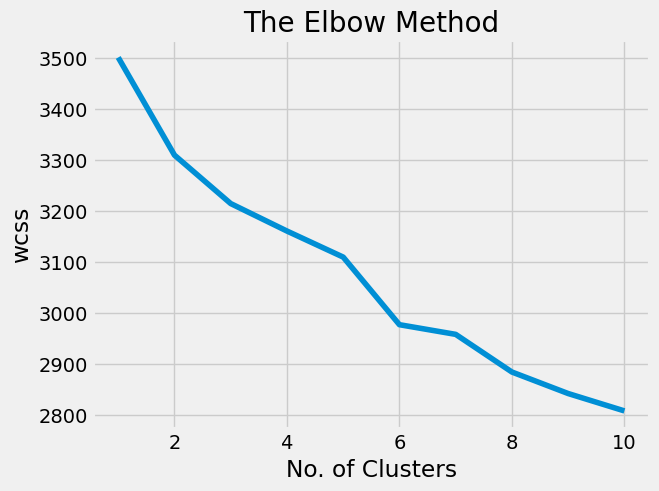

In [24]:
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

Scegliamo 6 cluster totali

In [27]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(rating_matrix)

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



In [28]:
n_clusters = 5
kMeansClusterer = KMeansClusterer(n_clusters, cosine_distance)

clusters = kMeansClusterer.cluster(rating_matrix, assign_clusters=True)
users_clusters = dict(zip(users_subset, clusters))

In [29]:
# Vediamo quanti user_id sono presenti per ciascun cluster
user_per_cluster = []
for i in range(n_clusters):
    user_per_cluster.append(len([x for x in users_clusters.values() if x == i]))
    print('Cluster', i, 'utenti:', user_per_cluster[i])

Cluster 0 utenti: 11
Cluster 1 utenti: 973
Cluster 2 utenti: 8
Cluster 3 utenti: 1
Cluster 4 utenti: 7


Text(0, 0.5, 'User')

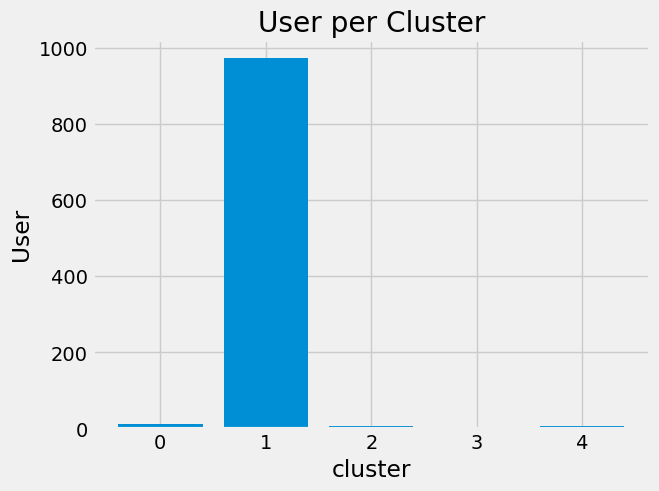

In [30]:
#user_per_cluster = np.sort(user_per_cluster)
plt.bar(range(n_clusters),user_per_cluster)
plt.title('User per Cluster')
plt.xlabel('cluster')
plt.ylabel('User')

In [32]:
cl1 = []
cl2 = []
cl3 = []
cl4 = []
cl5 = []
for i in(users_clusters):
    cluster = users_clusters[i]
    if cluster == 0:
        cl1.append(i)
    if cluster == 1:
        cl2.append(i)
    if cluster == 2:
        cl3.append(i)
    if cluster == 3:
        cl4.append(i)
    if cluster == 4:
        cl5.append(i)

In [34]:
print('------------------------------------------------')
print('CLUSTER 1: ', cl1[0:5],'....')
print('------------------------------------------------')
print('CLUSTER 2: ', cl2[0:5],'....')
print('------------------------------------------------')
print('CLUSTER 3: ', cl3[0:5],'....')
print('------------------------------------------------')
print('CLUSTER 4: ', cl4[0:5],'....')
print('------------------------------------------------')
print('CLUSTER 5: ', cl5[0:5],'....')
print('------------------------------------------------')

------------------------------------------------
CLUSTER 1:  [388317, 640417, 321, 60467, 693436] ....
------------------------------------------------
CLUSTER 2:  [151944, 154309, 87660, 721308, 16800] ....
------------------------------------------------
CLUSTER 3:  [855337, 564111, 146771, 9259, 234649] ....
------------------------------------------------
CLUSTER 4:  [279765] ....
------------------------------------------------
CLUSTER 5:  [53519, 728539, 251897, 768140, 41133] ....
------------------------------------------------


# Creiamo per ogni utente la lista degli item

In [35]:
df_ridotto.set_index(['user_id', 'item_id'], inplace=True) 


diz = {}
for i, user in enumerate(users_subset):
    lista_item = []
    for j, item in enumerate(items_ids):
        if (user, item) in df_ridotto.index:
            pass
        else:
            if rating_matrix[i, j] == 5:
                    lista_item.append(item)
            else:
                pass        
    diz[user] = lista_item
  

df_ridotto.reset_index(inplace=True)

In [36]:
u = users_subset[:3]   # Item consigliati per i primi 3 utenti
for i in u:
    riga = diz[i]
    r = riga[:5]       # Primi 5 item consigliati
    print('------------------------------------------------')  
    print('user_id: ', i,'--> item_id',r)
print('------------------------------------------------')     

------------------------------------------------
user_id:  151944 --> item_id [1729232, 1295171, 123793, 1229740, 1133906]
------------------------------------------------
user_id:  154309 --> item_id [616682, 1295171, 123793, 1229740, 1133906]
------------------------------------------------
user_id:  87660 --> item_id [616682, 1729232, 123793, 1229740, 1133906]
------------------------------------------------


# Usiamo l'algoritmo SVD 

In [37]:
# n_factors (number of factors  '100')
# init_mean (sarebbe la media inziale con la quale si prate '0')
# init_std_dev (sarebbe la deviazione standard inziale con la quale si prate '1')
# n_epochs (sostanzilmente i cicli '20')
# lr_all  (learning rate '0.005')
# reg_all ( Il termine di regolarizzazione per tutti i parametri '0.02')
# biased (non ho capito bene cosa sia, ma sostanzialmente rende la stima imparziale 'True')

#param_grid = {
#    'n_factors': [40, 60, 80, 100, 120, 130],
#    'n_epochs': [10,20,30,40,50],
#    'lr_all': [0.01, 0.015,0.02],
#    'reg_all': [0.05,0.01],
#    'biased': [True, False],
#    'init_mean': [0,1,2,3,4,5],
#    'init_std_dev': [0.5,1,1.5]
#    }

# Proviamo a fare un grid serach per vedere di ottimizzare gli iperparametri:
# Utilizziamo il Grid Search:
ds_SVD = Dataset.load_from_df(df_ridotto.sample(frac=0.2)[['user_id', 'item_id', 'rating']], reader)
param_grid = {
    'n_factors': [40, 60],
    'n_epochs': [10],
    'lr_all': [0.01],
    'reg_all': [0.05],
    'biased': [True, False],
    'init_mean': [0,1],
    'init_std_dev': [0.5]
    }


gs_SVD = GridSearchCV(SVD, param_grid, measures=['rmse', 'mse'], n_jobs = -1)
gs_SVD.fit(ds_SVD)


# Vediamo i risultati:
print(f'Best RMSE = {gs_SVD.best_score["rmse"]:.4f}')
print(f'Best MSE = {gs_SVD.best_score["mse"]:.4f}')
print(f'Best configuration = {gs_SVD.best_params["rmse"]}')

Best RMSE = 0.8437
Best MSE = 0.7138
Best configuration = {'n_factors': 40, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.05, 'biased': False, 'init_mean': 1, 'init_std_dev': 0.5}


Best RMSE = 0.7585
Best MSE = 0.5761
Best configuration = {'n_factors': 40, 'n_epochs': 40, 'lr_all': 0.02, 'reg_all': 0.05, 'biased': True, 'init_mean': 1, 'init_std_dev': 0.5}

In [38]:
# Cross validiamo:
gs_SVD = Dataset.load_from_df(df_ridotto.sample(frac=0.2)[['user_id', 'item_id', 'rating']], reader)

algo_SVD_2 = SVD(
    n_factors= 40, 
    n_epochs= 40,
    lr_all=  0.02,
    reg_all= 0.05,
    biased= True,
    init_mean= 1,
    init_std_dev= 0.5
    )

result_SVD = cross_validate(algo_SVD_2, ds_SVD, measures=['RMSE', 'MSE'], cv=5, verbose=True)

Evaluating RMSE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7206  0.7431  0.7911  0.7406  0.7779  0.7547  0.0259  
MSE (testset)     0.5192  0.5522  0.6259  0.5485  0.6051  0.5702  0.0393  
Fit time          0.16    0.14    0.14    0.15    0.16    0.15    0.01    
Test time         0.01    0.01    0.02    0.01    0.02    0.01    0.00    


In [39]:
# Ora fittiamo il modello:
ds_SVD = Dataset.load_from_df(df_ridotto, reader)
trainset_SVD = ds_SVD.build_full_trainset()

algo_SVD_2.fit(trainset_SVD)

In [40]:
for i in range(1,10):
  (algo_SVD_2.predict(df_ridotto.sample().iloc[0,0],df_ridotto.sample().iloc[0,1],  r_ui = 2 ,verbose= True).est)

user: 777527     item: 1615177    r_ui = 2.00   est = 4.07   {'was_impossible': False}
user: 8259       item: 131698     r_ui = 2.00   est = 4.57   {'was_impossible': False}
user: 902971     item: 1608617    r_ui = 2.00   est = 4.75   {'was_impossible': False}
user: 504685     item: 168610     r_ui = 2.00   est = 4.17   {'was_impossible': False}
user: 996936     item: 1793377    r_ui = 2.00   est = 4.35   {'was_impossible': False}
user: 162679     item: 126335     r_ui = 2.00   est = 4.88   {'was_impossible': False}
user: 933313     item: 1226293    r_ui = 2.00   est = 4.07   {'was_impossible': False}
user: 441640     item: 1209909    r_ui = 2.00   est = 4.72   {'was_impossible': False}
user: 713027     item: 1831026    r_ui = 2.00   est = 3.93   {'was_impossible': False}


Filling Della matrice con SVD

In [43]:
# Creaiamo prima una matrice con l'SVD:
matrice_vuota_SVD = np.zeros((len(users_subset), len(items_ids)))
df_ridotto.set_index(['user_id', 'item_id'], inplace=True) 

for i, user in enumerate(users_subset):
    for j, item in enumerate(items_ids):

        if (user, item) in df_ridotto.index:
            matrice_vuota_SVD[i, j] = df_ridotto.loc[user, item]['rating']

        else:
            matrice_vuota_SVD[i, j] = round(algo_SVD_2.predict(user, item).est)

df_ridotto.reset_index(inplace=True)

In [44]:
matrice_vuota_SVD[:10,:10]

array([[5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [5., 5., 4., 4., 4., 5., 4., 4., 3., 5.],
       [5., 5., 5., 5., 5., 5., 5., 5., 4., 4.],
       [5., 5., 5., 5., 5., 5., 5., 4., 5., 5.],
       [5., 4., 4., 5., 5., 5., 4., 4., 4., 5.],
       [5., 4., 5., 4., 5., 5., 4., 5., 4., 5.],
       [5., 5., 4., 4., 4., 4., 5., 4., 4., 4.],
       [4., 5., 5., 5., 5., 5., 5., 4., 5., 5.],
       [5., 4., 5., 4., 5., 5., 5., 5., 5., 5.],
       [4., 4., 5., 4., 4., 4., 4., 5., 3., 3.]])

In [45]:
from sklearn.cluster import KMeans
wcss_SVD = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(matrice_vuota_SVD)
    wcss_SVD.append(km.inertia_)

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are l

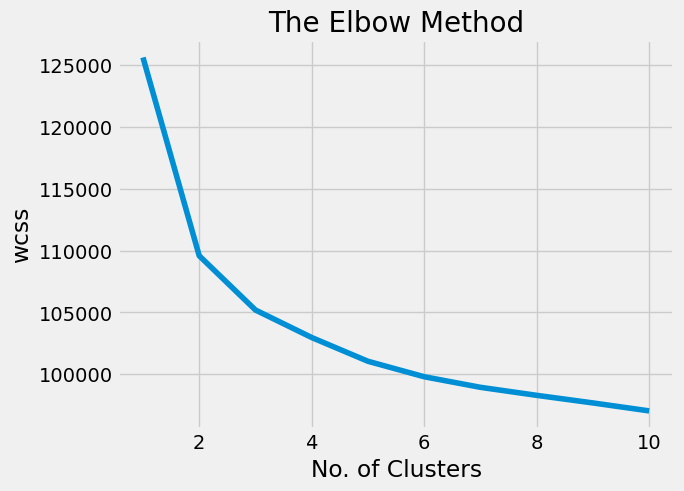

In [46]:
plt.plot(range(1, 11), wcss_SVD)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
# Teniamo come buoni 3 cluster

In [55]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(matrice_vuota_SVD)

C:\Users\lorym\.conda\NConda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



In [56]:
n_clusters = 3
kMeansClusterer = KMeansClusterer(n_clusters, cosine_distance)

clusters = kMeansClusterer.cluster(matrice_vuota_SVD, assign_clusters=True)
users_clusters = dict(zip(users_subset, clusters))

In [57]:
# Vediamo quanti user_id sono presenti per ciascun cluster
user_per_cluster_SVD = []
for i in range(n_clusters):
    user_per_cluster.append(len([x for x in users_clusters.values() if x == i]))
    print('Cluster', i, 'utenti:', user_per_cluster[i])

Cluster 0 utenti: 11
Cluster 1 utenti: 973
Cluster 2 utenti: 8


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (0,).

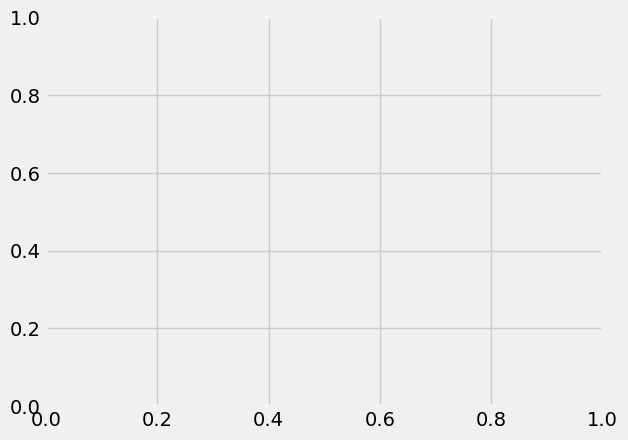

In [58]:
#user_per_cluster = np.sort(user_per_cluster)
plt.bar(range(n_clusters),user_per_cluster_SVD)
plt.title('User per Cluster')
plt.xlabel('cluster')
plt.ylabel('User')

In [53]:
cl1 = []
cl2 = []
cl3 = []
for i in(user_per_cluster_SVD):
    cluster = user_per_cluster_SVD[i]
    if cluster == 0:
        cl1.append(i)
    if cluster == 1:
        cl2.append(i)
    if cluster == 2:
        cl3.append(i)

In [54]:
print('------------------------------------------------')
print('CLUSTER 1: ', cl1,'...')
print('------------------------------------------------')
print('CLUSTER 2: ', cl2[0:5],'...')
print('------------------------------------------------')
print('CLUSTER 3: ', cl3[0:5],'...')
print('------------------------------------------------')

------------------------------------------------
CLUSTER 1:  [] ...
------------------------------------------------
CLUSTER 2:  [] ...
------------------------------------------------
CLUSTER 3:  [] ...
------------------------------------------------


In [59]:
# Creiamo per ogni utente la lista degli item
df_ridotto.set_index(['user_id', 'item_id'], inplace=True) 


diz_SVD = {}
for i, user in enumerate(users_subset):
    lista_item = []
    for j, item in enumerate(items_ids):
        if (user, item) in df_ridotto.index:
            pass
        else:
            if matrice_vuota_SVD[i, j] == 5:
                    lista_item.append(item)
            else:
                pass        
    diz_SVD[user] = lista_item
  

df_ridotto.reset_index(inplace=True)

In [67]:
u = users_subset[:3]   # Item consigliati per i primi 3 utenti
for i in u:
    riga = diz_SVD[i]
    r = riga[:5]       # Primi 5 item consigliati
    print('------------------------------------------------')  
    print('user_id: ', i,'--> item_id',r)
print('------------------------------------------------')   

------------------------------------------------
user_id:  151944 --> item_id [1729232, 1295171, 123793, 1229740, 1133906]
------------------------------------------------
user_id:  154309 --> item_id [616682, 1133906, 1126889, 1009845, 838983]
------------------------------------------------
user_id:  87660 --> item_id [616682, 1729232, 123793, 1229740, 1133906]
------------------------------------------------
